# Singles vs. Binaries IMF considerations

In [18]:
import cogsworth
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import gala.dynamics as gd
import os

In [19]:
import sys
sys.path.append("../src")
import plotting

In [20]:
import h5py as h5

In [21]:
%config InlineBackend.figure_format = 'retina'

pd.options.display.max_columns = 999

plt.rc('font', family='serif')
plt.rcParams['text.usetex'] = False
fs = 24

# update various fontsizes to match
params = {'figure.figsize': (12, 8),
          'legend.fontsize': fs,
          'axes.labelsize': fs,
          'xtick.labelsize': 0.9 * fs,
          'ytick.labelsize': 0.9 * fs,
          'axes.linewidth': 1.1,
          'xtick.major.size': 7,
          'xtick.minor.size': 4,
          'ytick.major.size': 7,
          'ytick.minor.size': 4}
plt.rcParams.update(params)

In [22]:
from importlib import reload
reload(plotting)

<module 'plotting' from '/mnt/home/twagg/supernova-feedback/notebooks/../src/plotting.py'>

# Sample two different ways

In [1]:
from cosmic.sample.sampler.independent import InitialBinaryTable

In [179]:
import cosmic

In [267]:
binaries, _, mass_binaries, _, _ = InitialBinaryTable().sampler("independent", range(16), range(16),
                                                                primary_model="kroupa01",
                                                                ecc_model="sana12",
                                                                porb_model="sana12",#{"min": 5.0, "max": 5.5, "slope": -0.55},
                                                                SF_start=10000,
                                                                SF_duration=0,
                                                                binfrac_model=1.0,
                                                                met=0.02, m2_min=0.0, qmin=0.0,
                                                                size=300000, keep_singles=True)
singles, mass_singles, yn, _, _ = InitialBinaryTable().sampler("independent", range(16), range(16),
                                                    "kroupa01", "sana12", {"min": 5.0, "max": 5.5, "slope": -0.55},
                                                    10000, 0, 0.0, 0.02,
                                                    total_mass=mass_binaries,
                                                    sampling_target="total_mass",
                                                    keep_singles=True,
                                                    trim_extra_samples=True)

In [268]:
mass_binaries, mass_singles

(263421.33898955357, 263421.2803986742)

In [269]:
singles["mass_1"].sum()

263421.28039867594

In [270]:
(binaries["mass_1"] + binaries["mass_2"]).sum()

263421.33898955106

In [271]:
(binaries["mass_1"] >= 4).sum() + (binaries["mass_2"] >= 4).sum()

6788

In [272]:
(singles["mass_1"] >= 4).sum()

7109

In [273]:
(binaries["mass_2"] >= 4).sum()

2029

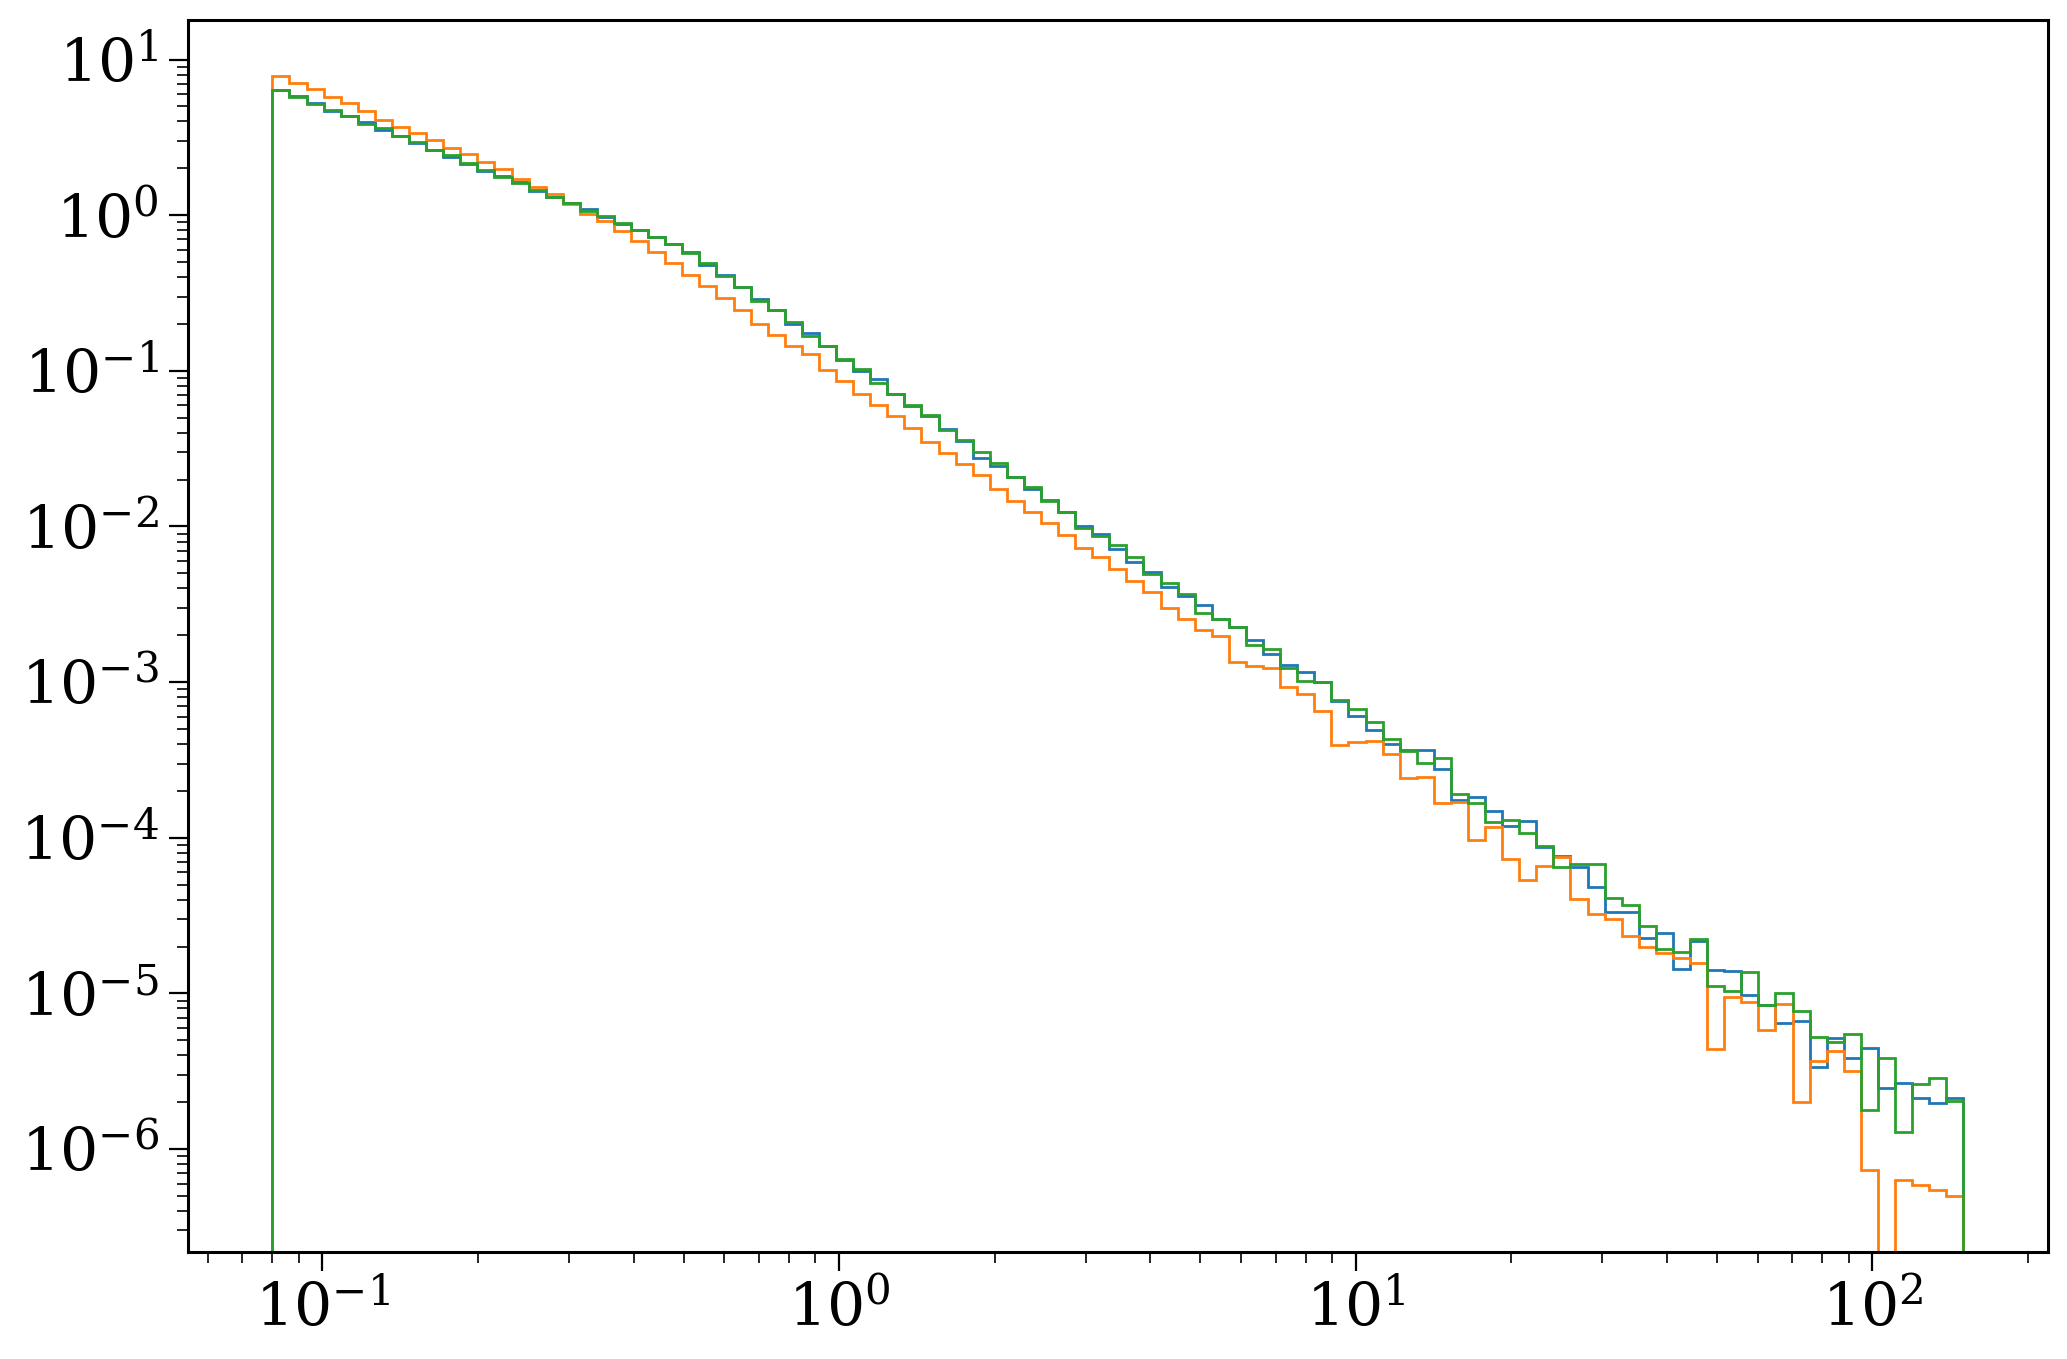

In [274]:
for thing in [binaries["mass_1"],
              binaries["mass_2"],
              singles["mass_1"]]:
    plt.hist(thing, np.geomspace(0.08, 150, 100), histtype="step", density=True)
plt.xscale("log")
plt.yscale("log")
plt.show()

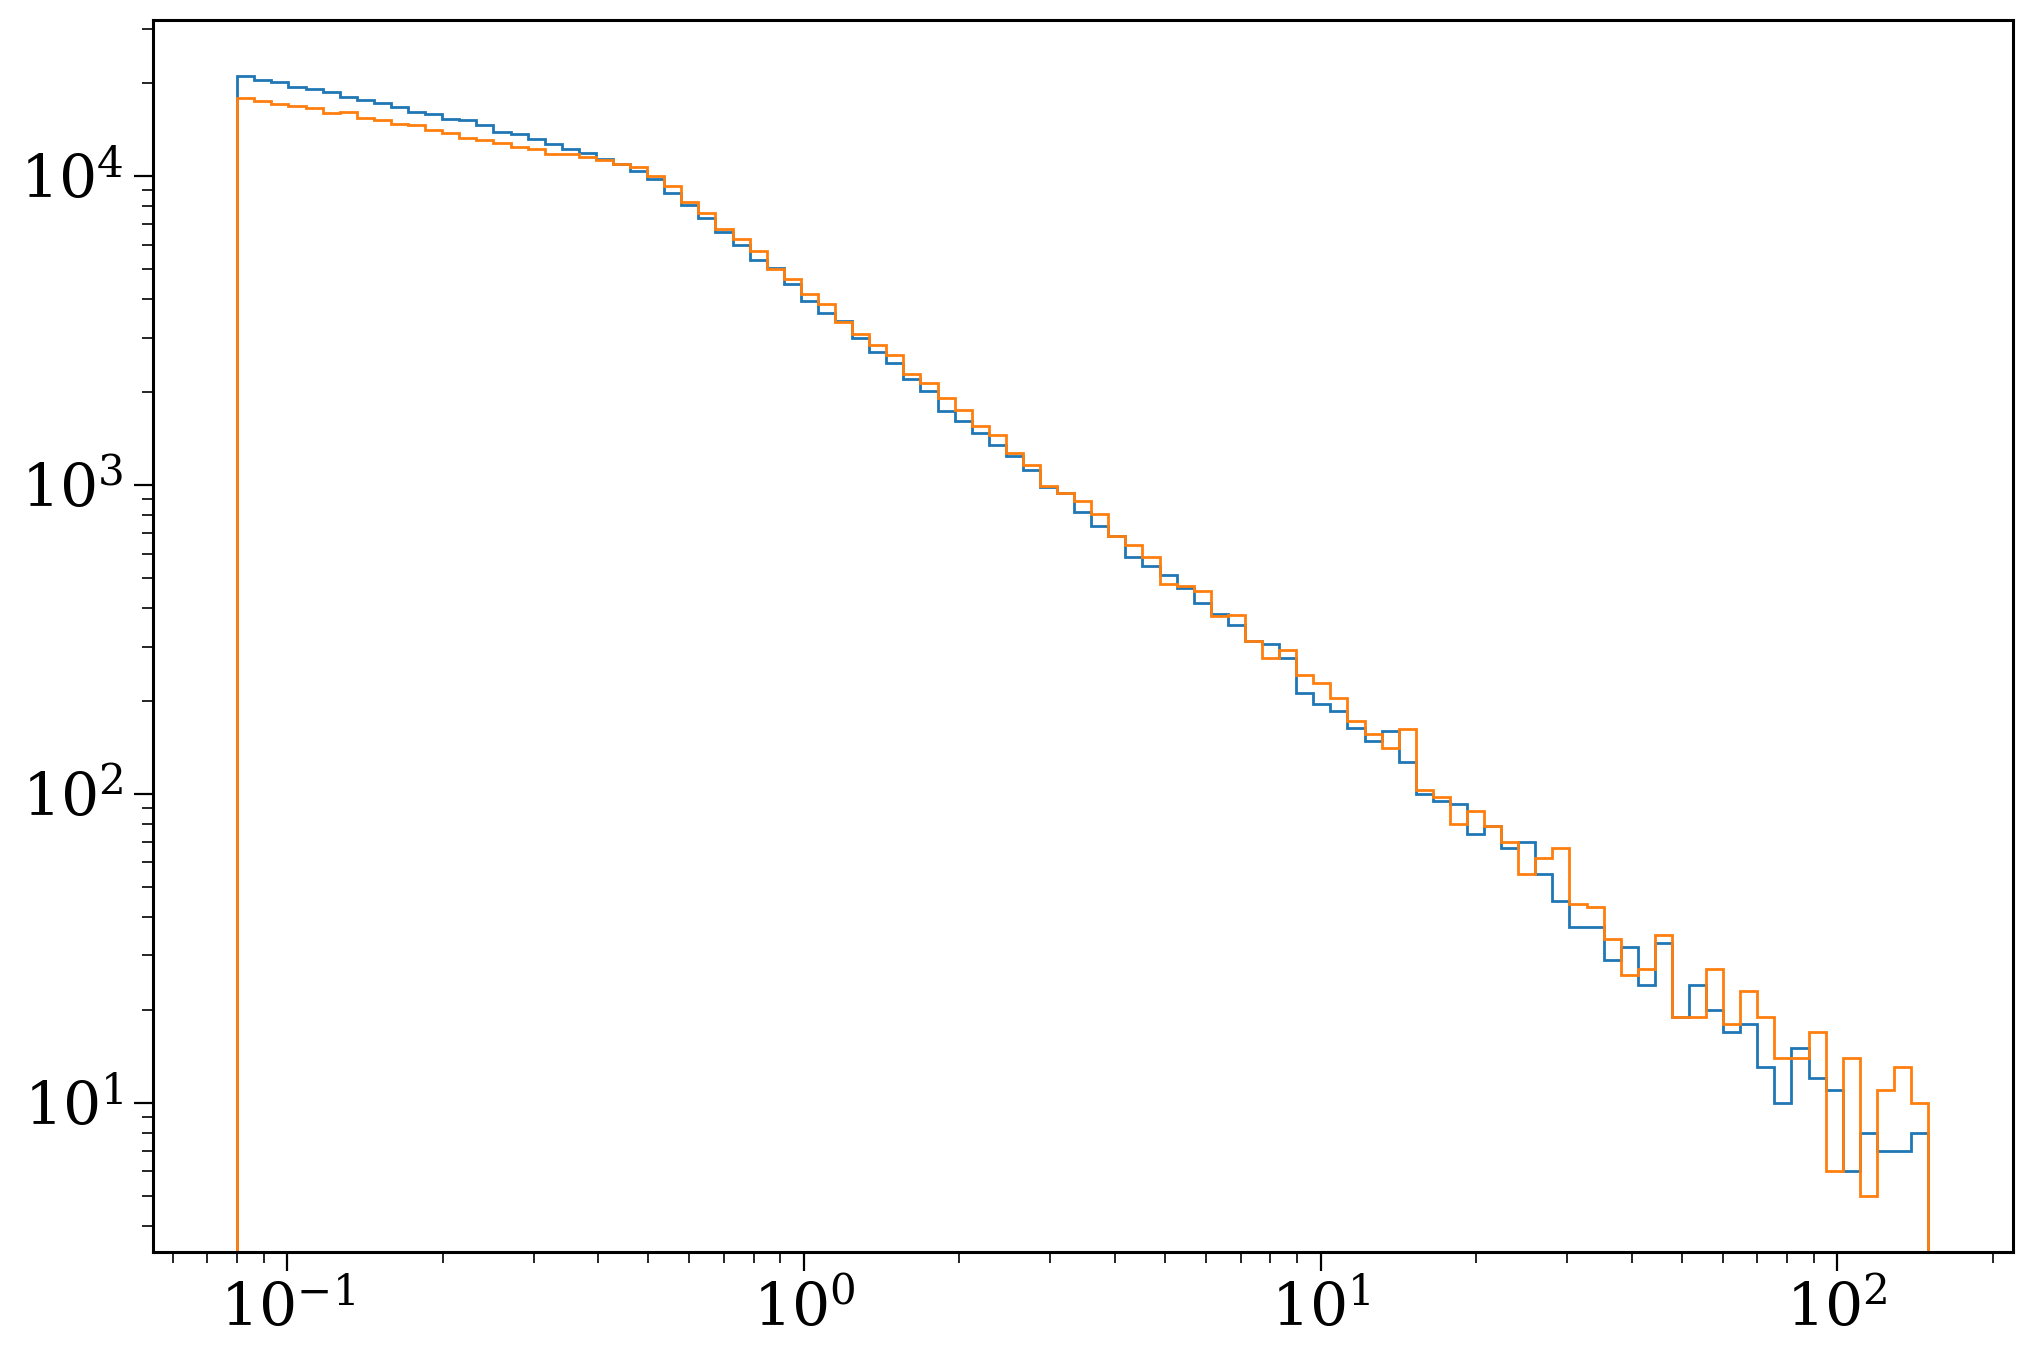

In [278]:
for thing in [np.concatenate((binaries["mass_1"], binaries["mass_2"])),
              singles["mass_1"]]:
    plt.hist(thing, np.geomspace(0.08, 150, 100), histtype="step", density=False)
plt.xscale("log")
plt.yscale("log")
plt.show()

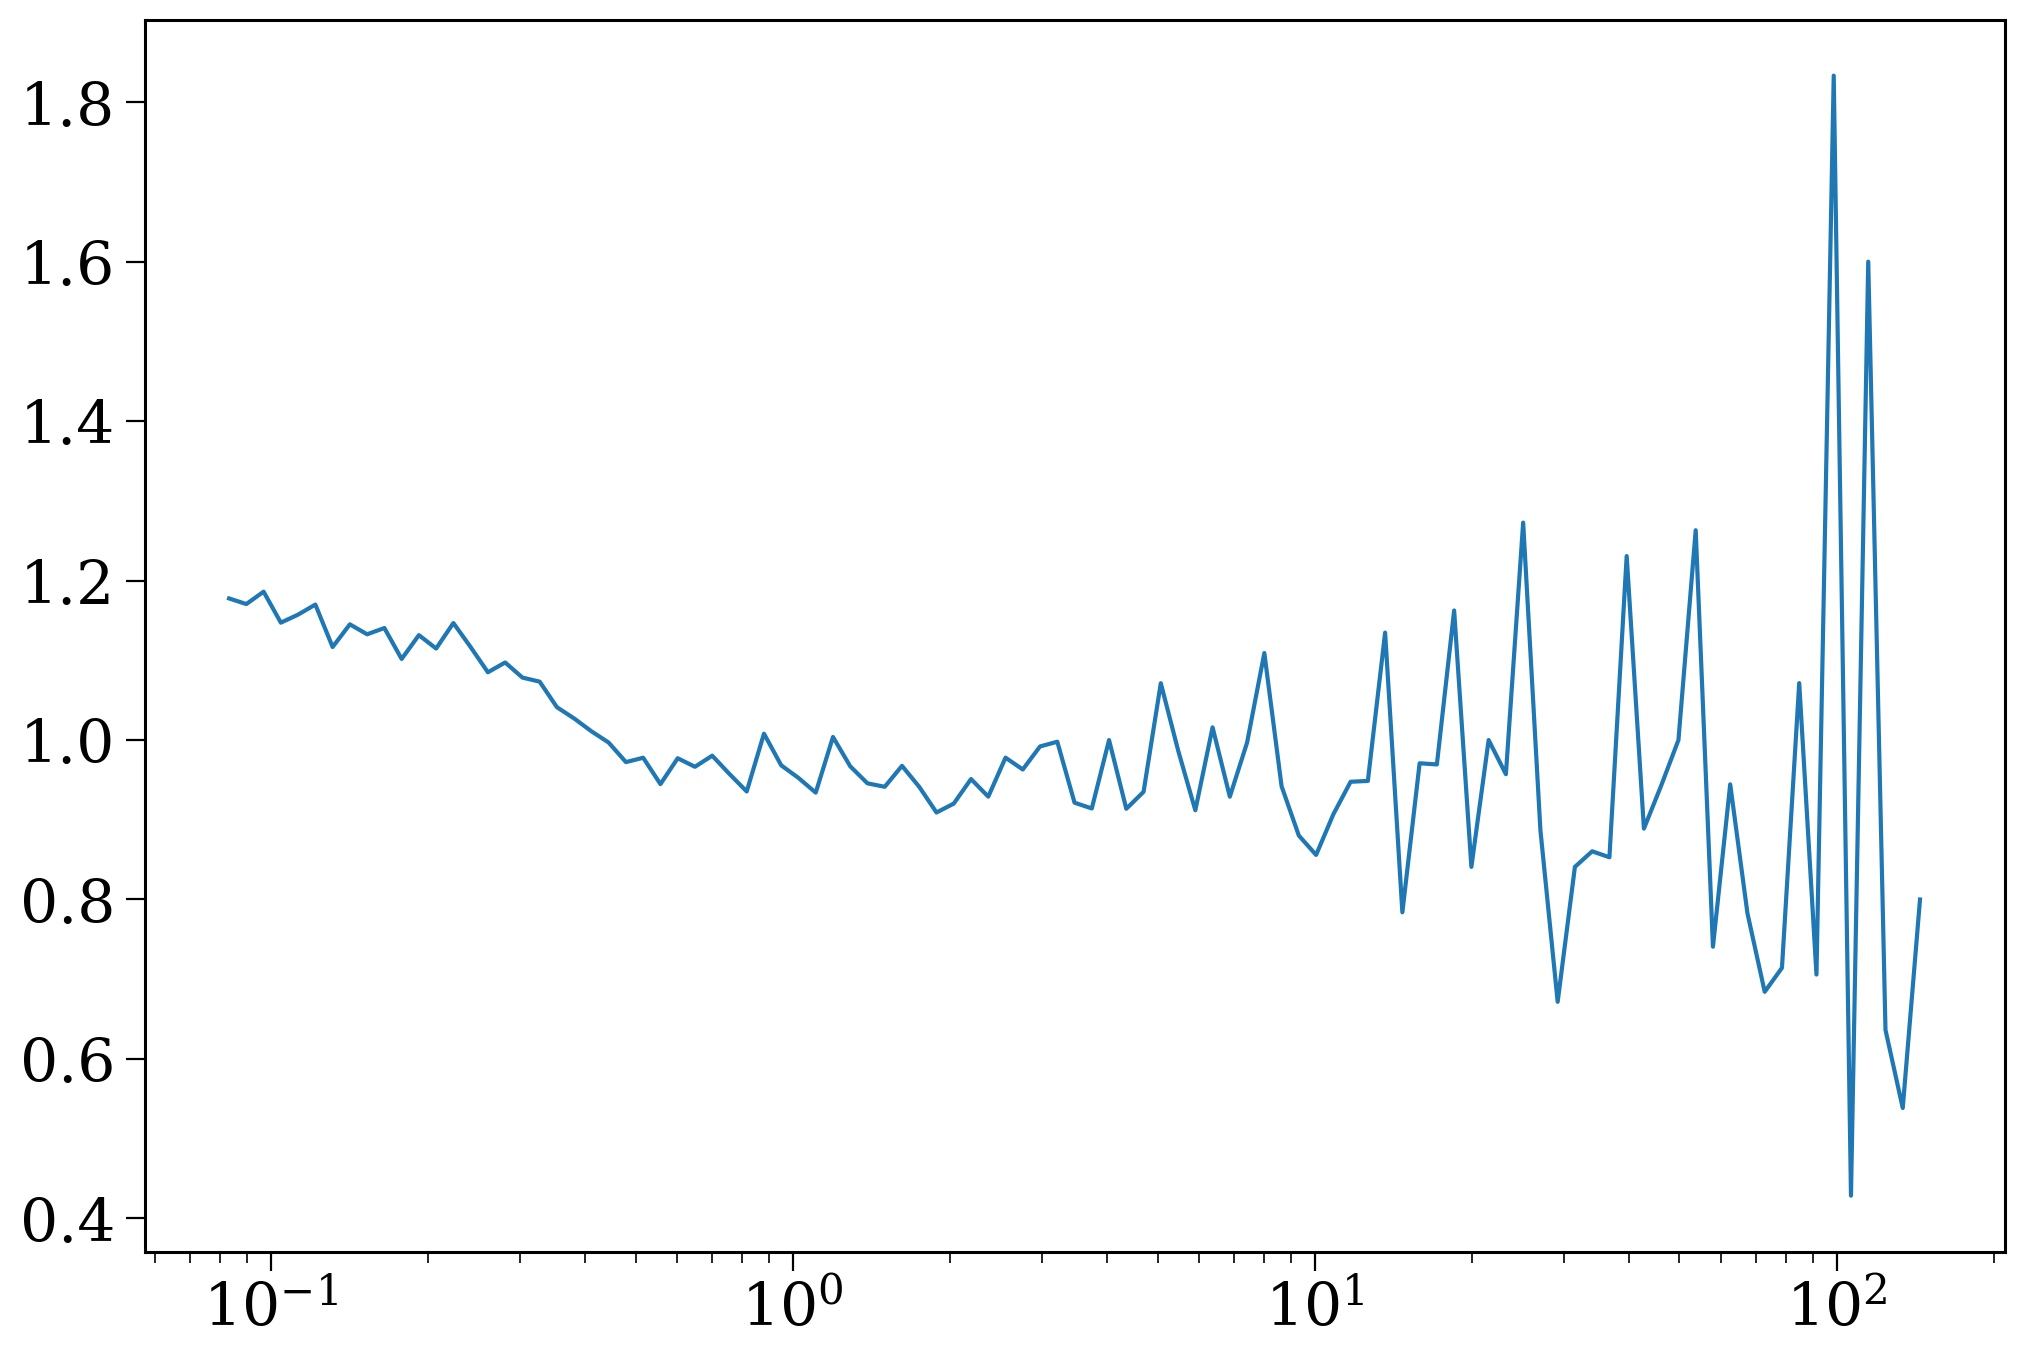

In [284]:
hists = []
for thing in [np.concatenate((binaries["mass_1"], binaries["mass_2"])),
              singles["mass_1"]]:
    hists.append(np.histogram(thing, np.geomspace(0.08, 150, 100))[0])

centres, _ = plotting.get_centres_widths(np.geomspace(0.08, 150, 100))
plt.plot(centres, hists[0] / hists[1])
plt.xscale("log")
# plt.yscale("log")
plt.show()

In [203]:
(x["mass_1"] + y["mass_1"]).sum()

201923.66937967227

# Compare populations

In [68]:
%%time
test = cogsworth.pop.load(f"/mnt/home/twagg/ceph/pops/feedback-variations/fiducial.h5", parts=[])

CPU times: user 759 ms, sys: 201 µs, total: 759 ms
Wall time: 764 ms


In [72]:
test.BSE_settings["binfrac"]

0.5

In [71]:
test.sampling_params

{'primary_model': 'kroupa01',
 'ecc_model': 'sana12',
 'porb_model': 'sana12',
 'qmin': -1,
 'keep_singles': False}

In [69]:
test.mass_binaries + test.mass_singles

73062583.0714364

In [50]:
pops = {file_name: cogsworth.pop.load(f"/mnt/home/twagg/ceph/pops/feedback-variations/{file_name}.h5", parts=[])
        if os.path.isfile(f"/mnt/home/twagg/ceph/pops/feedback-variations/{file_name}.h5") else None
        for file_name in ["fiducial", "singles", "kiel_method/singles"]}

In [51]:
(pops["fiducial"].mass_binaries + pops["fiducial"].mass_singles) / pops["kiel_method/singles"].mass_singles

10.19687499353811

In [55]:
def get_total_sn(p):
    return p.sn_1.sum() + p.sn_2.sum() + p.sn_1_singles.sum() + p.sn_2_singles.sum() + p.sn_1_merger.sum() + p.sn_2_merger.sum()

In [ ]:
for p in pops:
    plotting.set_sn_subpop_masks(pops[p])

In [93]:
pops["fiducial"].mass_binaries / (pops["fiducial"].mass_binaries + pops["fiducial"].mass_singles)

0.6079073892741783

In [76]:
pops[p].sn_truly_single.sum()

80839

In [77]:
51140 / 46596

1.0975191003519615

In [94]:
51140 / (80839 * 0.4)

1.5815386137878993

In [90]:
def sn_demographics(p, norm=False, show=False, mod=1):
    norm_vals = [mod, mod, mod, mod] if not norm else [pops["fiducial"].sn_1_singles.sum() + pops["fiducial"].sn_2_singles.sum(),
                                            pops["fiducial"].sn_1.sum(),
                                            pops["fiducial"].sn_2.sum(),
                                            pops["fiducial"].sn_1_merger.sum() + pops["fiducial"].sn_2_merger.sum()]
    sn_singles = (p.sn_1_singles.sum() + p.sn_2_singles.sum()) / norm_vals[0]
    sn_1 = p.sn_1.sum() / norm_vals[1]
    sn_2 = p.sn_2.sum() / norm_vals[2]
    sn_M = (p.sn_1_merger.sum() + p.sn_2_merger.sum()) / norm_vals[3]
    total = ((p.sn_truly_single.sum() / 2 + p.sn_1_singles.sum() + p.sn_2_singles.sum()) + p.sn_1.sum() + p.sn_2.sum() + (p.sn_1_merger.sum() + p.sn_2_merger.sum())) / np.sum(norm_vals)

    if show:
        print(p._file.split("/")[-1].split(".h5")[0])
        print(f"  SN S: {sn_singles}")
        print(f"  SN 1: {sn_1}")
        print(f"  SN 2: {sn_2}")
        print(f"  SN M: {sn_M}")
        print(f"  TOT : {total}")
    return [sn_1, sn_2, sn_M, sn_singles, total]

In [86]:
pops["fiducial"].sn_2_singles.sum()

396

In [91]:
for p in pops:
    # print(get_total_sn(pops[p]))
    sn_demographics(pops[p], norm=True, show=True);

fiducial
  SN S: 1.0
  SN 1: 1.0
  SN 2: 1.0
  SN M: 1.0
  TOT : 1.0
singles
  SN S: 45.37098344693281
  SN 1: 0.0
  SN 2: 0.0
  SN M: 0.0
  TOT : 0.9111458740711772
singles
  SN S: 0.0
  SN 1: 0.0
  SN 2: 0.0
  SN M: 0.0
  TOT : 0.7903695737192022


In [63]:
pops[p].bpp[pops[p].bpp["evol_type"] == 15]

,tphys,mass_1,mass_2,kstar_1,kstar_2,sep,porb,ecc,RRLO_1,RRLO_2,evol_type,aj_1,aj_2,tms_1,tms_2,massc_1,massc_2,rad_1,rad_2,mass0_1,mass0_2,lum_1,lum_2,teff_1,teff_2,radc_1,radc_2,menv_1,menv_2,renv_1,renv_2,omega_spin_1,omega_spin_2,B_1,B_2,bacc_1,bacc_2,tacc_1,tacc_2,epoch_1,epoch_2,bhspin_1,bhspin_2,bin_num
1,18.196629,10.721758,0.0,5.0,15.0,0.0,0.0,-1.0,0.0001,1.000000e-20,15.0,18.947650,0.0,16.916095,1.000000e+10,3.715417,0.0,1291.652556,1.000000e-10,12.118066,0.0,117561.471152,1.000000e-10,2987.191123,1.833452e+06,4.718167,1.000000e-10,5.056899e+00,1.000000e-10,1.185836e+03,1.000000e-10,2.061167e+14,NaN,0.0,0.0,0.0,0.0,0.0,0.0,-0.751849,0.0,0.0,0.0,1
2,8.971247,7.150002,0.0,5.0,15.0,0.0,0.0,-1.0,0.0001,1.000000e-20,15.0,9.372107,0.0,8.410188,1.000000e+10,7.136937,0.0,1.871036,1.000000e-10,19.880817,0.0,211309.395264,1.000000e-10,90877.893469,1.833452e+06,1.319589,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,8.762619e-01,NaN,0.0,0.0,0.0,0.0,0.0,0.0,-0.401681,0.0,0.0,0.0,2
4,4.164041,11.181094,0.0,8.0,15.0,0.0,0.0,-1.0,0.0001,1.000000e-20,15.0,0.604510,0.0,0.584975,1.000000e+10,8.606413,0.0,1.102173,1.000000e-10,11.603974,0.0,358035.974293,1.000000e-10,135091.002829,1.833452e+06,0.000070,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,5.568454e-02,NaN,0.0,0.0,0.0,0.0,0.0,0.0,3.559063,0.0,0.0,0.0,4
5,36.346822,7.986678,0.0,5.0,15.0,0.0,0.0,-1.0,0.0001,1.000000e-20,15.0,37.029980,0.0,32.875544,1.000000e+10,2.303822,0.0,611.361064,1.000000e-10,8.430982,0.0,32883.417547,1.000000e-10,3157.657047,1.833452e+06,14.781574,1.000000e-10,5.684704e+00,1.000000e-10,5.965795e+02,1.000000e-10,2.636136e+14,NaN,0.0,0.0,0.0,0.0,0.0,0.0,-0.684855,0.0,0.0,0.0,5
6,10.062832,6.325979,0.0,5.0,15.0,0.0,0.0,-1.0,0.0001,1.000000e-20,15.0,10.500694,0.0,9.413697,1.000000e+10,6.314270,0.0,1.685124,1.000000e-10,18.117626,0.0,176744.007265,1.000000e-10,91577.718047,1.833452e+06,1.204455,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.089352e+00,NaN,0.0,0.0,0.0,0.0,0.0,0.0,-0.437863,0.0,0.0,0.0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194230,7.732272,6.808344,0.0,8.0,15.0,0.0,0.0,-1.0,0.0001,1.000000e-20,15.0,0.873324,0.0,0.832017,1.000000e+10,5.155370,0.0,1.161714,1.000000e-10,7.135214,0.0,192998.940566,1.000000e-10,112747.974976,1.833452e+06,0.000070,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,9.423882e-01,NaN,0.0,0.0,0.0,0.0,0.0,0.0,6.858294,0.0,0.0,0.0,194230
194231,8.839031,6.516434,0.0,8.0,15.0,0.0,0.0,-1.0,0.0001,1.000000e-20,15.0,0.907526,0.0,0.863154,1.000000e+10,4.921331,0.0,1.224137,1.000000e-10,6.831549,0.0,182029.015620,1.000000e-10,108240.494957,1.833452e+06,0.000070,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000636e+00,NaN,0.0,0.0,0.0,0.0,0.0,0.0,7.930859,0.0,0.0,0.0,194231
194235,6.606246,7.213889,0.0,8.0,15.0,0.0,0.0,-1.0,0.0001,1.000000e-20,15.0,0.831967,0.0,0.793904,1.000000e+10,5.486716,0.0,1.113341,1.000000e-10,7.556717,0.0,209507.477906,1.000000e-10,117558.858792,1.833452e+06,0.000070,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,8.396919e-01,NaN,0.0,0.0,0.0,0.0,0.0,0.0,5.774003,0.0,0.0,0.0,194235
194237,29.252562,8.614064,0.0,5.0,15.0,0.0,0.0,-1.0,0.0001,1.000000e-20,15.0,30.107868,0.0,26.765839,1.000000e+10,2.617307,0.0,845.377445,1.000000e-10,9.312563,0.0,49112.813923,1.000000e-10,2968.540559,1.833452e+06,12.333066,1.000000e-10,4.716433e+00,1.000000e-10,7.844096e+02,1.000000e-10,2.325665e+14,NaN,0.0,0.0,0.0,0.0,0.0,0.0,-0.856409,0.0,0.0,0.0,194237
